# Data pre-processing using the images separated with corresponding masks

In [1]:
import os
import torch
import numpy as np
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from PIL import Image

# Define your images and masks directories
images_dir = "/Users/maryamrehmatulla/Desktop/test_images"
masks_dir = "/Users/maryamrehmatulla/Desktop/test_masks"

# List all files in the images and masks directories
all_image_files = os.listdir(images_dir)
all_mask_files = os.listdir(masks_dir)

# Filter image files to match the expected pattern (just numbers)
all_images = [f for f in all_image_files if f.replace('.png', '').isdigit() and f.endswith('.png')]

# Debug: Print the filtered list of image files
print("Filtered images:", all_images)

# Ensure that we have corresponding mask files
all_images = [f for f in all_images if f in all_mask_files]

# Debug: Print the filtered list of image files with corresponding masks
print("Images with corresponding masks:", all_images)

# Check if there are any images left after filtering
if not all_images:
    raise ValueError("No valid images found in the directory that match the expected pattern.")

# Sort the image filenames to ensure consistent ordering
all_images.sort()

# Create a dictionary to map each image filename to its corresponding mask filename
image_to_mask = {}
for img_name in all_images:
    mask_name = img_name  # Assuming mask names are the same as image names
    image_to_mask[img_name] = mask_name

# Split data into training, validation, and testing sets (80%, 10%, 10%)
train_images, val_test_images = train_test_split(all_images, test_size=0.2, random_state=42)
val_images, test_images = train_test_split(val_test_images, test_size=0.5, random_state=42)

print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")
print(f"Testing images: {len(test_images)}")

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
])

def preprocess_data(image_list, images_dir, masks_dir, transform):
    images = []
    masks = []
    
    for img_name in image_list:
        img_path = os.path.join(images_dir, img_name)
        mask_name = image_to_mask[img_name]
        mask_path = os.path.join(masks_dir, mask_name)  # Assuming mask names are the same as image names
        
        try:
            # Read images and masks
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L")
            
            # Apply transformations
            img = transform(img)
            mask = transform(mask)
            
            # Append to lists
            images.append(img)
            masks.append(mask)
        except Exception as e:
            print(f"Error processing file {img_name}: {e}")
    
    return torch.stack(images), torch.stack(masks)

# Preprocess data
train_images_tensor, train_masks_tensor = preprocess_data(train_images, images_dir, masks_dir, transform)
val_images_tensor, val_masks_tensor = preprocess_data(val_images, images_dir, masks_dir, transform)
test_images_tensor, test_masks_tensor = preprocess_data(test_images, images_dir, masks_dir, transform)

print(f"Train images tensor shape: {train_images_tensor.shape}")
print(f"Validation images tensor shape: {val_images_tensor.shape}")
print(f"Test images tensor shape: {test_images_tensor.shape}")

# Convert datasets to TensorDataset
train_dataset = TensorDataset(train_images_tensor, train_masks_tensor)
val_dataset = TensorDataset(val_images_tensor, val_masks_tensor)
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)

# Define batch size
batch_size = 2

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Filtered images: ['77.png', '63.png', '62.png', '76.png', '60.png', '74.png', '48.png', '49.png', '75.png', '61.png', '59.png', '65.png', '71.png', '70.png', '64.png', '58.png', '8.png', '72.png', '66.png', '67.png', '73.png', '9.png', '14.png', '28.png', '29.png', '15.png', '17.png', '16.png', '12.png', '13.png', '39.png', '11.png', '10.png', '38.png', '35.png', '21.png', '20.png', '34.png', '22.png', '36.png', '37.png', '23.png', '27.png', '33.png', '32.png', '26.png', '18.png', '30.png', '24.png', '25.png', '31.png', '19.png', '4.png', '56.png', '42.png', '43.png', '5.png', '57.png', '41.png', '55.png', '7.png', '69.png', '68.png', '54.png', '6.png', '40.png', '78.png', '44.png', '2.png', '50.png', '3.png', '51.png', '45.png', '1.png', '47.png', '46.png', '52.png']
Images with corresponding masks: ['77.png', '63.png', '62.png', '76.png', '60.png', '74.png', '48.png', '49.png', '75.png', '61.png', '59.png', '65.png', '71.png', '70.png', '64.png', '58.png', '8.png', '72.png', '66.png'

In [4]:
def load_test_data(test_images_dir, test_masks_dir, transform):
    test_images = []
    test_masks = []
    
    test_filenames = os.listdir(test_images_dir)
    
    for filename in test_filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(test_images_dir, filename)
            mask_name = filename.replace(".png", "_mask.png")
            mask_path = os.path.join(test_masks_dir, mask_name)
            
            try:
                # Read images and masks
                img = Image.open(img_path).convert("RGB")
                
                # Check if mask file exists
                if os.path.exists(mask_path):
                    mask = Image.open(mask_path).convert("L")
                    
                    # Apply transformations
                    img = transform(img)
                    mask = transform(mask)
                    
                    # Binarize the mask (optional)
                    mask = (mask > 0.5).float()
                    
                    # Append to lists
                    test_images.append(img)
                    test_masks.append(mask)
                else:
                    print(f"Mask file not found for image {filename}. Skipping...")
            
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    return torch.stack(test_images), torch.stack(test_masks)


Test Set - Accuracy: 0.5705, Precision: 0.5705, F1-Score: 0.7265, IoU: 0.5705


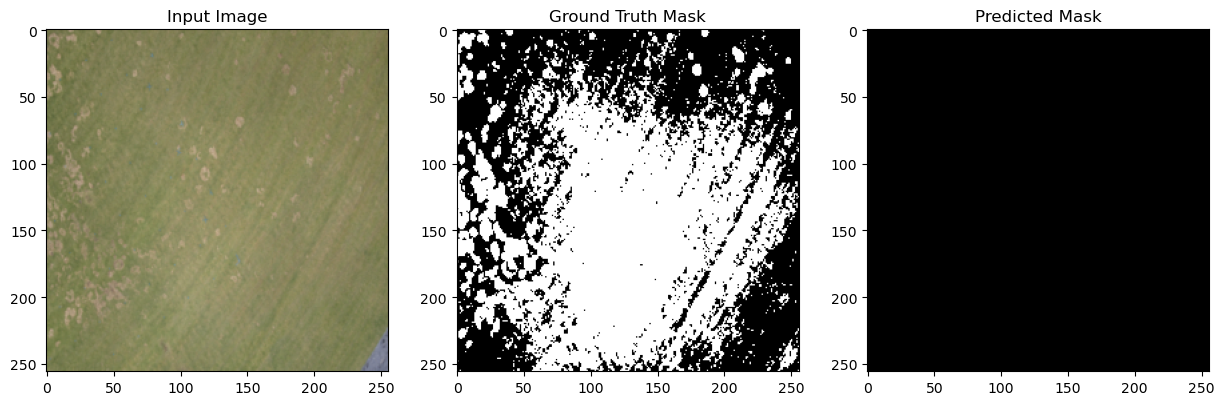

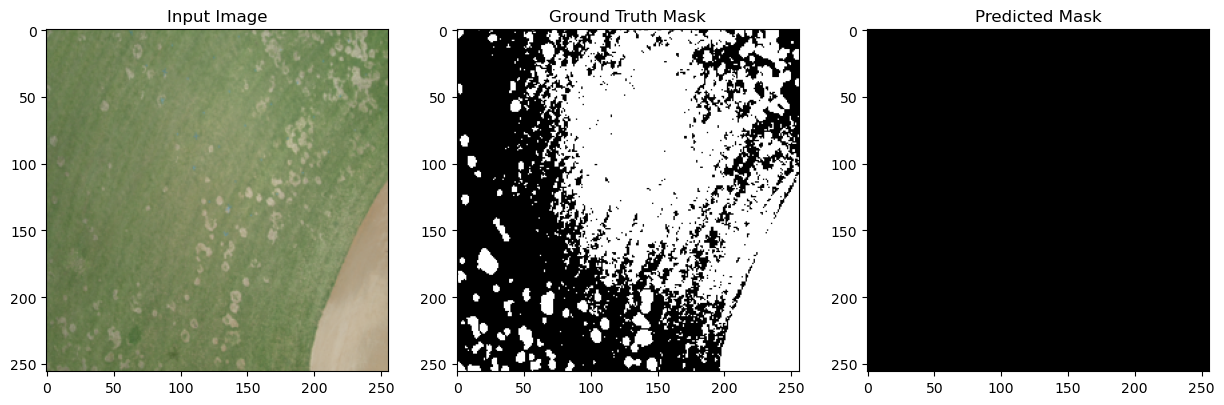

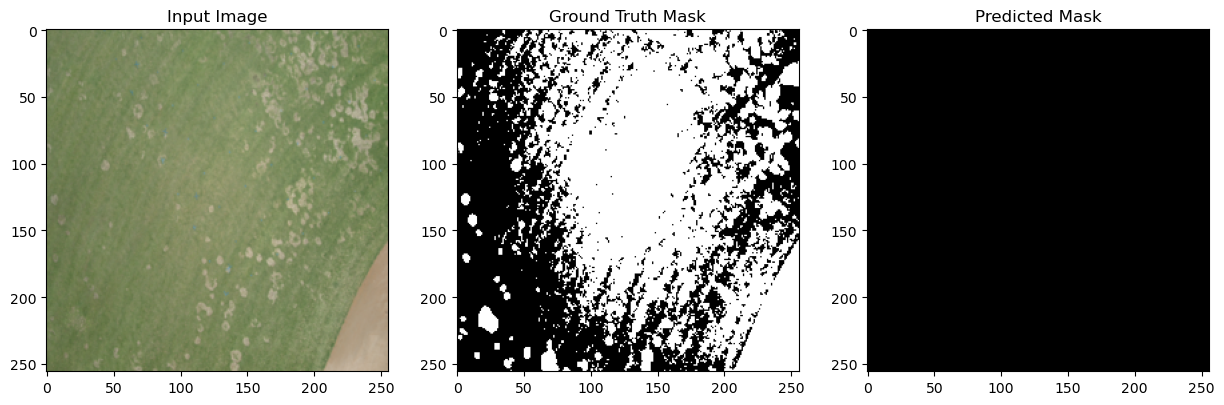

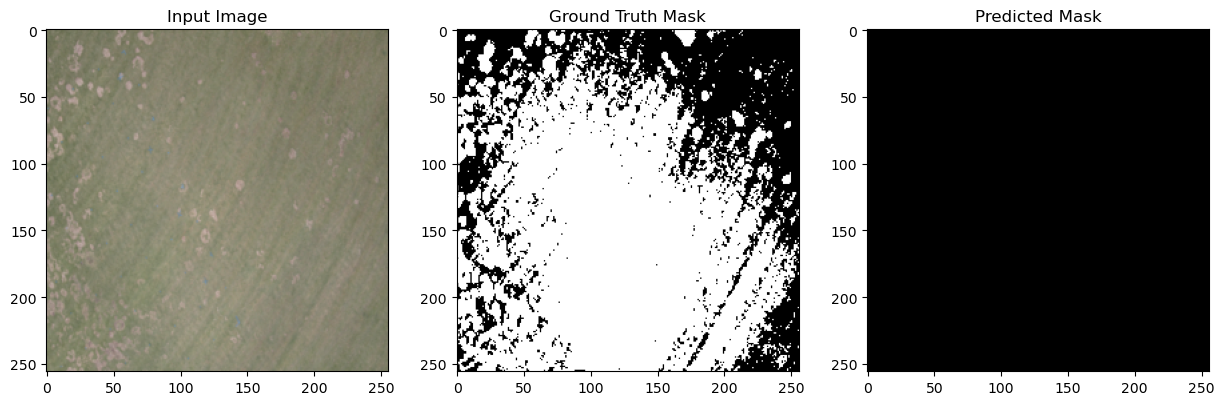

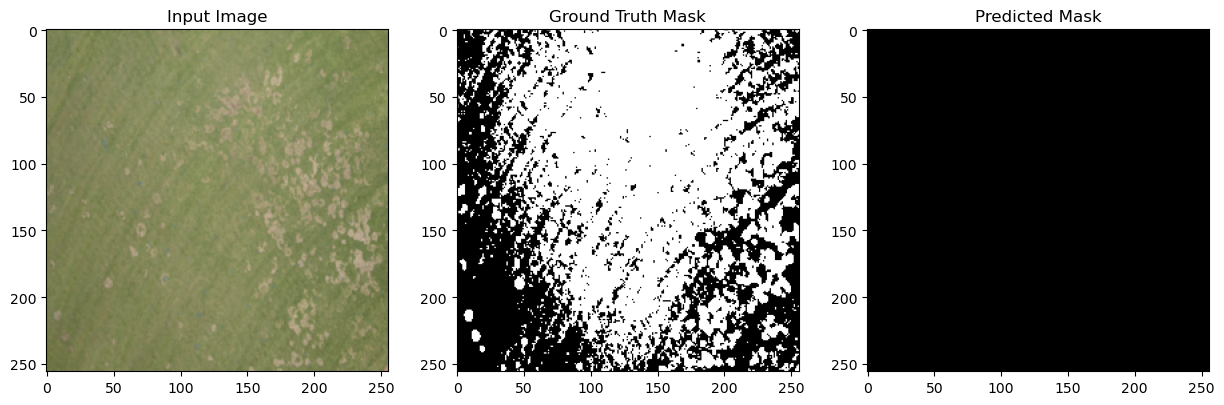

In [5]:
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, jaccard_score
from PIL import Image
import matplotlib.pyplot as plt
from Model import UNet  # Import your U-Net model

# Define your images and masks directories
images_dir = "/Users/maryamrehmatulla/Desktop/images"
masks_dir = "/Users/maryamrehmatulla/Desktop/masks"
test_images_dir = "/Users/maryamrehmatulla/Desktop/test_images"  # Adjust as per your test images directory
test_masks_dir = "/Users/maryamrehmatulla/Desktop/test_masks"    # Adjust as per your test masks directory

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to Tensor
    transforms.Resize((256, 256)),  # Resize images and masks to (256, 256)
])

# Function to load test images and masks
def load_test_data(test_images_dir, test_masks_dir, transform):
    test_images = []
    test_masks = []
    # Get all test image filenames
    test_filenames = os.listdir(test_images_dir)
    
    for filename in test_filenames:
        if filename.endswith('.png'):
            img_path = os.path.join(test_images_dir, filename)
            mask_path = os.path.join(test_masks_dir, filename)
            
            try:
                # Read images and masks
                img = Image.open(img_path).convert("RGB")
                mask = Image.open(mask_path).convert("L")
                
                # Apply transformations
                img = transform(img)
                mask = transform(mask)
                
                # Binarize the mask
                mask = (mask > 0.5).float()
                
                # Append to lists
                test_images.append(img)
                test_masks.append(mask)
            except Exception as e:
                print(f"Error processing file {filename}: {e}")
    
    return torch.stack(test_images), torch.stack(test_masks)

# Load test data
test_images_tensor, test_masks_tensor = load_test_data(test_images_dir, test_masks_dir, transform)

# Convert datasets to TensorDataset
test_dataset = TensorDataset(test_images_tensor, test_masks_tensor)
# Define batch size
batch_size = 2

# Create DataLoader for test set
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Instantiate your U-Net model
model = UNet(n_class=1)  # Adjust n_class according to your task (e.g., number of classes for segmentation)

# Load model weights if needed
# model.load_state_dict(torch.load('path_to_your_model_weights.pth'))

model.eval()  # Set model to evaluation mode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Choose device

# Function to perform inference and calculate metrics
def evaluate_model(loader):
    predictions = []
    targets = []
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device)
            
            # Perform inference
            outputs = model(images)
            
            # Apply sigmoid activation to get probabilities
            outputs = torch.sigmoid(outputs)
            
            # Append predictions (outputs) and targets (masks) to the lists
            predictions.append(outputs.cpu())
            targets.append(masks.cpu())
    
    # Concatenate predictions and targets
    predictions_tensor = torch.cat(predictions, dim=0)
    targets_tensor = torch.cat(targets, dim=0)
    
    # Threshold predictions to get binary masks
    binary_predictions_tensor = (predictions_tensor > 0.5).float()
    
    # Ensure targets are binary
    binary_targets_tensor = (targets_tensor > 0.5).float()
    
    # Calculate metrics
    accuracy, precision, f1, iou = calculate_metrics(binary_predictions_tensor, binary_targets_tensor)
    
    return accuracy, precision, f1, iou

# Function to calculate metrics
def calculate_metrics(predictions, targets):
    # Flatten the tensors for metric calculation
    pred_flat = predictions.view(-1).cpu().numpy()
    target_flat = targets.view(-1).cpu().numpy()
    
    # Calculate accuracy
    accuracy = accuracy_score(target_flat, pred_flat)
    
    # Calculate precision
    precision = precision_score(target_flat, pred_flat)
    # Calculate F1-score
    f1 = f1_score(target_flat, pred_flat)
    
    # Calculate IoU (Intersection over Union)
    iou = jaccard_score(target_flat, pred_flat)
    
    return accuracy, precision, f1, iou

# Evaluate model on test set
test_accuracy, test_precision, test_f1, test_iou = evaluate_model(test_loader)
print(f"Test Set - Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, F1-Score: {test_f1:.4f}, IoU: {test_iou:.4f}")

# Function to visualize predictions
def visualize_predictions(images, masks, predictions, num_images=5):
    # Ensure num_images does not exceed available images
    num_images = min(num_images, images.shape[0])
    
    for i in range(num_images):
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title('Input Image')
        
        plt.subplot(1, 3, 2)
        plt.imshow(masks[i].squeeze(), cmap='gray')
        plt.title('Ground Truth Mask')
        
        plt.subplot(1, 3, 3)
        plt.imshow(predictions[i].squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        
        plt.show()
        # Move test images and masks to device
test_images_tensor = test_images_tensor.to(device)
test_masks_tensor = test_masks_tensor.to(device)

# Perform inference on test set
with torch.no_grad():
    test_predictions = torch.sigmoid(model(test_images_tensor))

# Visualize predictions for the first 5 images in the test set
visualize_predictions(test_images_tensor.cpu(), test_masks_tensor.cpu(), (test_predictions > 0.5).float().cpu(), num_images=5)


In [27]:
# Perform inference on test set
with torch.no_grad():
    test_predictions = torch.sigmoid(model(test_images_tensor))

print("Shape of test predictions:", test_predictions.shape)  # Check shape of predictions

# Threshold predictions to get binary masks
binary_predictions = (test_predictions > 0.5).float()

Shape of test predictions: torch.Size([8, 1, 256, 256])


In [28]:
print("Minimum value in test predictions:", torch.min(test_predictions))
print("Maximum value in test predictions:", torch.max(test_predictions))

Minimum value in test predictions: tensor(0.5062)
Maximum value in test predictions: tensor(0.5124)


In [29]:
# Example: Adjust threshold based on the mean of test_predictions
threshold = test_predictions.mean()
binary_predictions = (test_predictions > threshold).float()

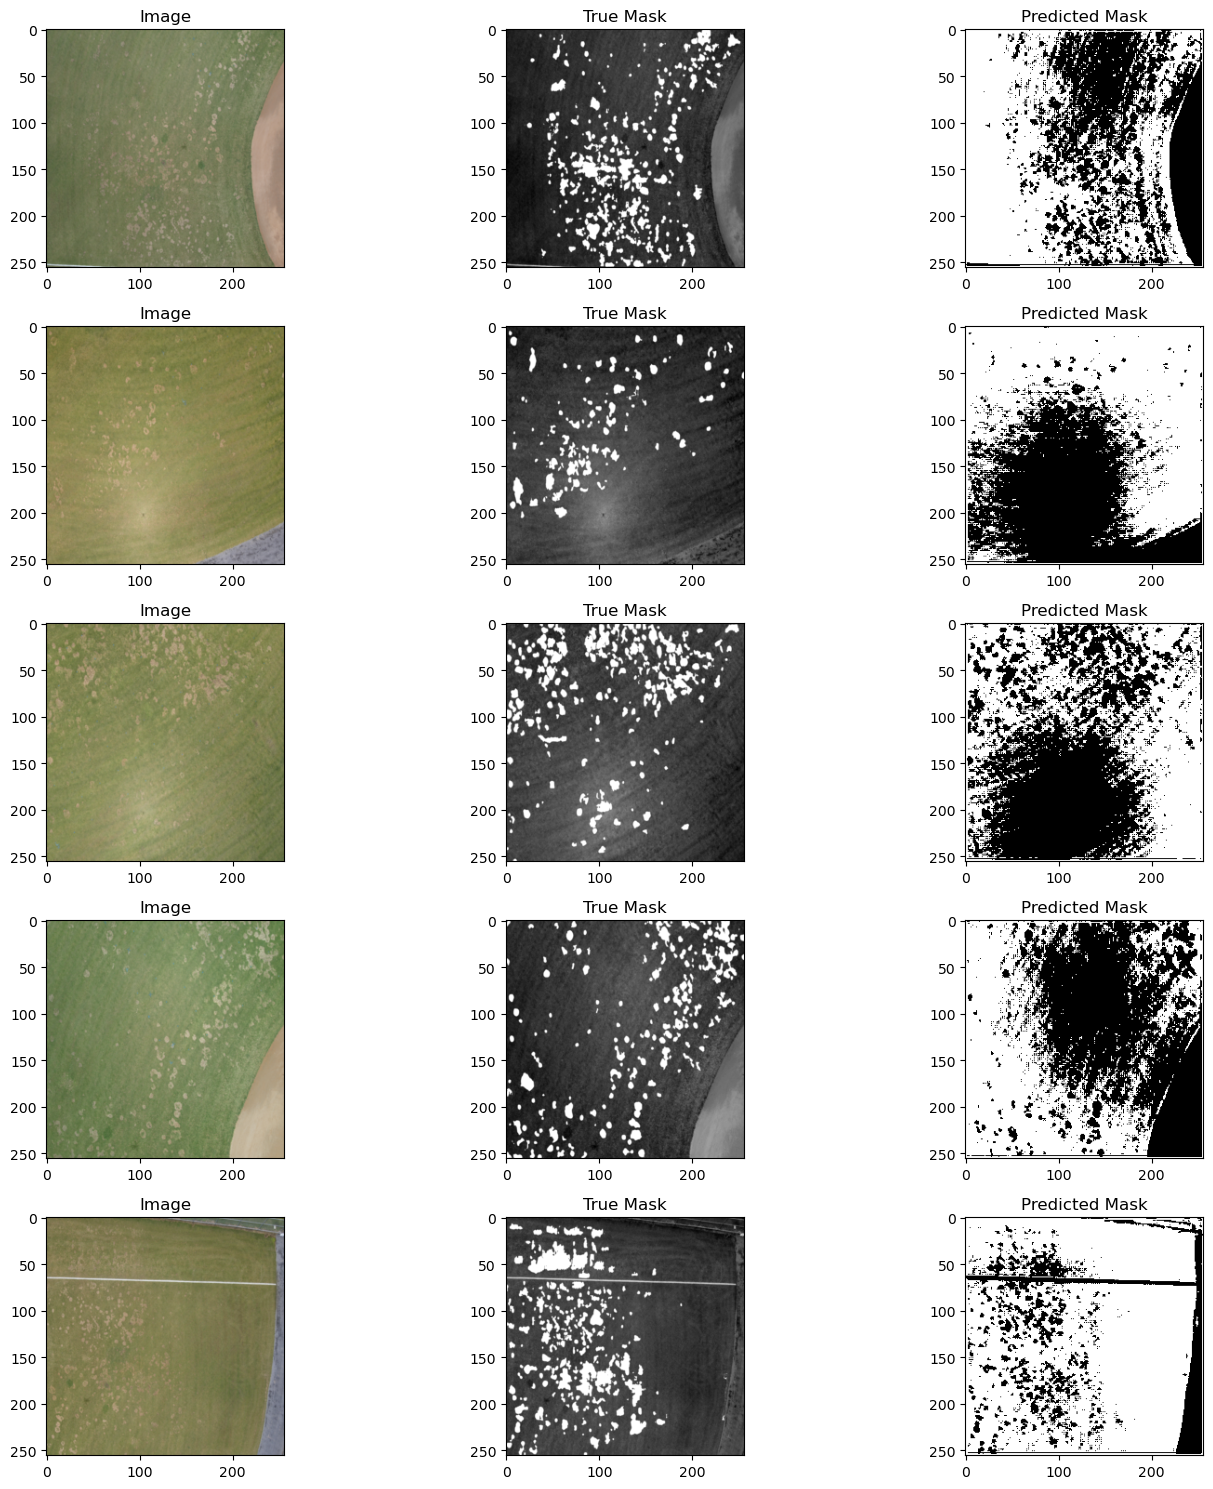

In [30]:
import matplotlib.pyplot as plt

def visualize_predictions(images, masks_true, masks_pred, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax[0].imshow(images[i].permute(1, 2, 0))  # Assuming images are in RGB format
        ax[0].set_title('Image')

        ax[1].imshow(masks_true[i].squeeze(), cmap='gray')  # True mask
        ax[1].set_title('True Mask')

        ax[2].imshow(masks_pred[i].squeeze(), cmap='gray')  # Predicted mask
        ax[2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Usage example:
visualize_predictions(test_images_tensor.cpu(), test_masks_tensor.cpu(), binary_predictions.cpu(), num_images=5)

Test Set - Accuracy: 0.1760, IoU: 0.1429


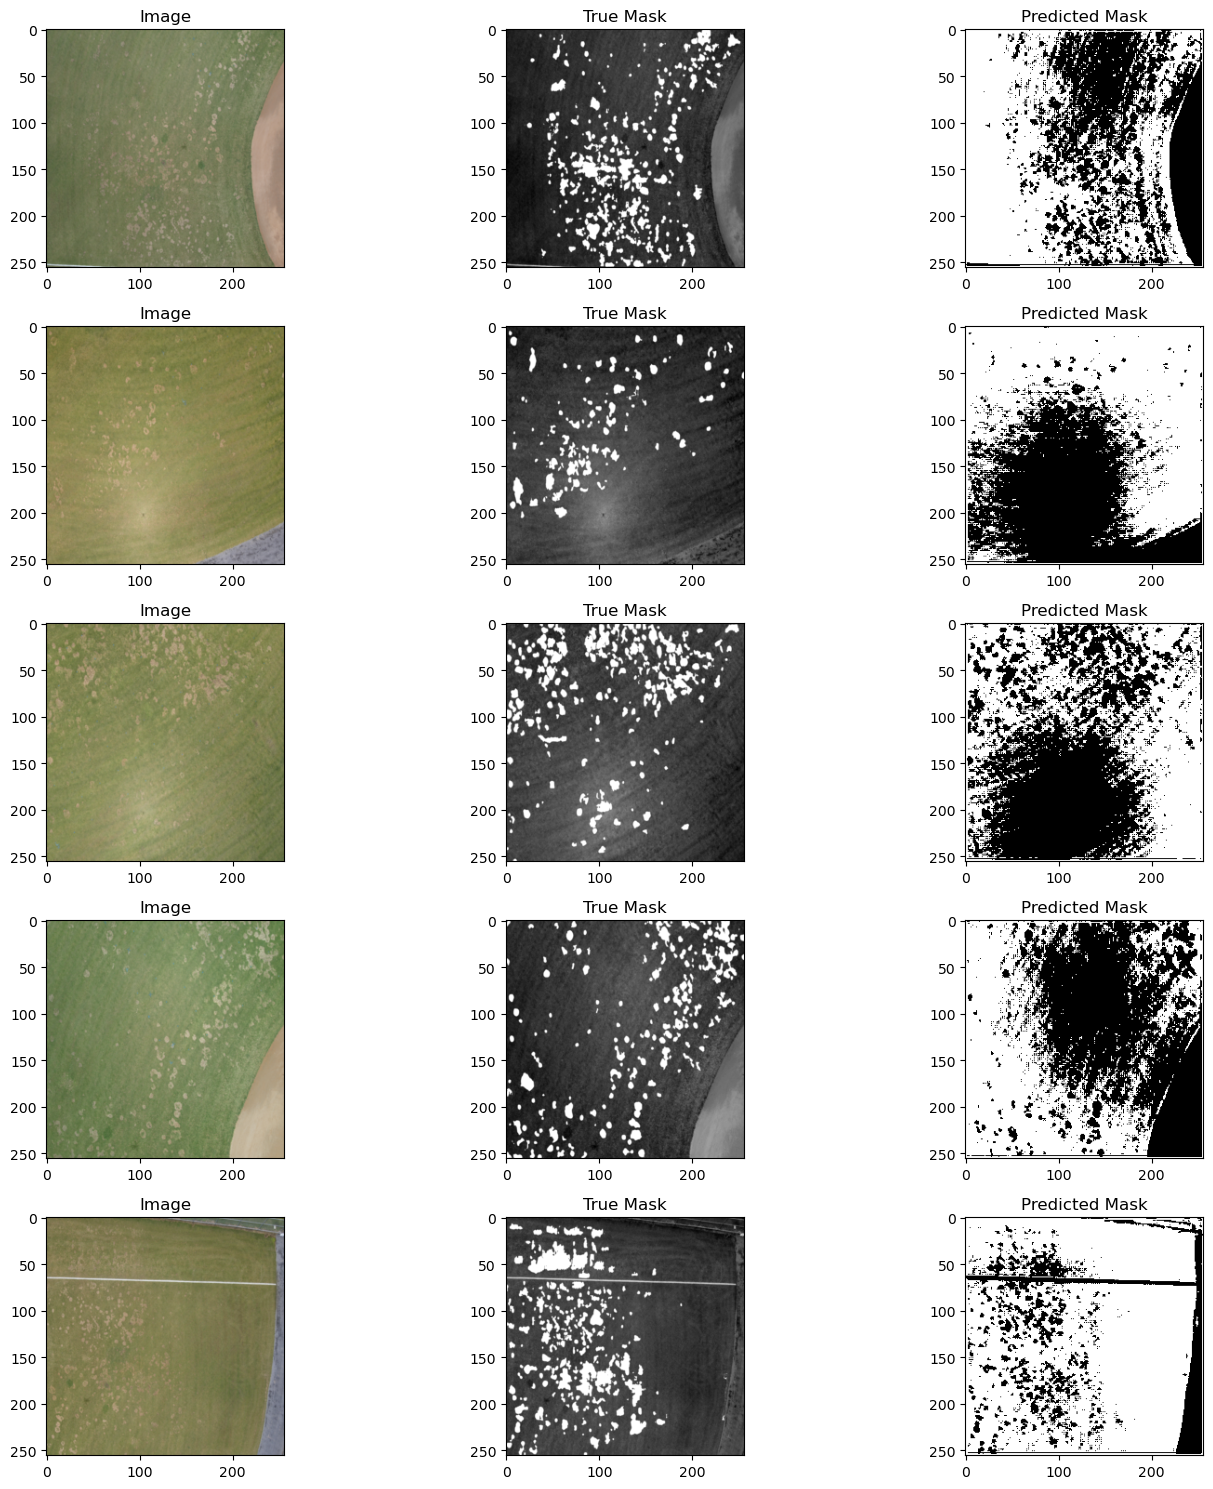

In [35]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score

def visualize_predictions(images, masks_true, masks_pred, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax[0].imshow(images[i].permute(1, 2, 0))  # Assuming images are in RGB format
        ax[0].set_title('Image')

        ax[1].imshow(masks_true[i].squeeze(), cmap='gray')  # True mask
        ax[1].set_title('True Mask')

        ax[2].imshow(masks_pred[i].squeeze(), cmap='gray')  # Predicted mask
        ax[2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

def evaluate_predictions(predictions, targets):
    # Ensure predictions and targets are on CPU and converted to numpy
    predictions = predictions.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    
    # Convert predictions to binary (0 or 1) based on threshold
    predictions_binary = (predictions > 0.5).astype(int)
    
    # Flatten tensors for metric calculation
    predictions_flat = predictions_binary.flatten()
    targets_flat = targets.flatten()
    
    # Ensure targets are binary (0 or 1)
    targets_binary = (targets_flat > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(targets_binary, predictions_flat)
    
    # Calculate IoU (Jaccard Index)
    iou = jaccard_score(targets_binary, predictions_flat)
    
    return accuracy, iou

# Example usage:
test_accuracy, test_iou = evaluate_predictions(binary_predictions, test_masks_tensor)
print(f"Test Set - Accuracy: {test_accuracy:.4f}, IoU: {test_iou:.4f}")

# Visualize predictions
visualize_predictions(test_images_tensor.cpu(), test_masks_tensor.cpu(), binary_predictions.cpu(), num_images=5)


# Improving Accuracy

Test Set - Accuracy: 0.4397, IoU: 0.0000


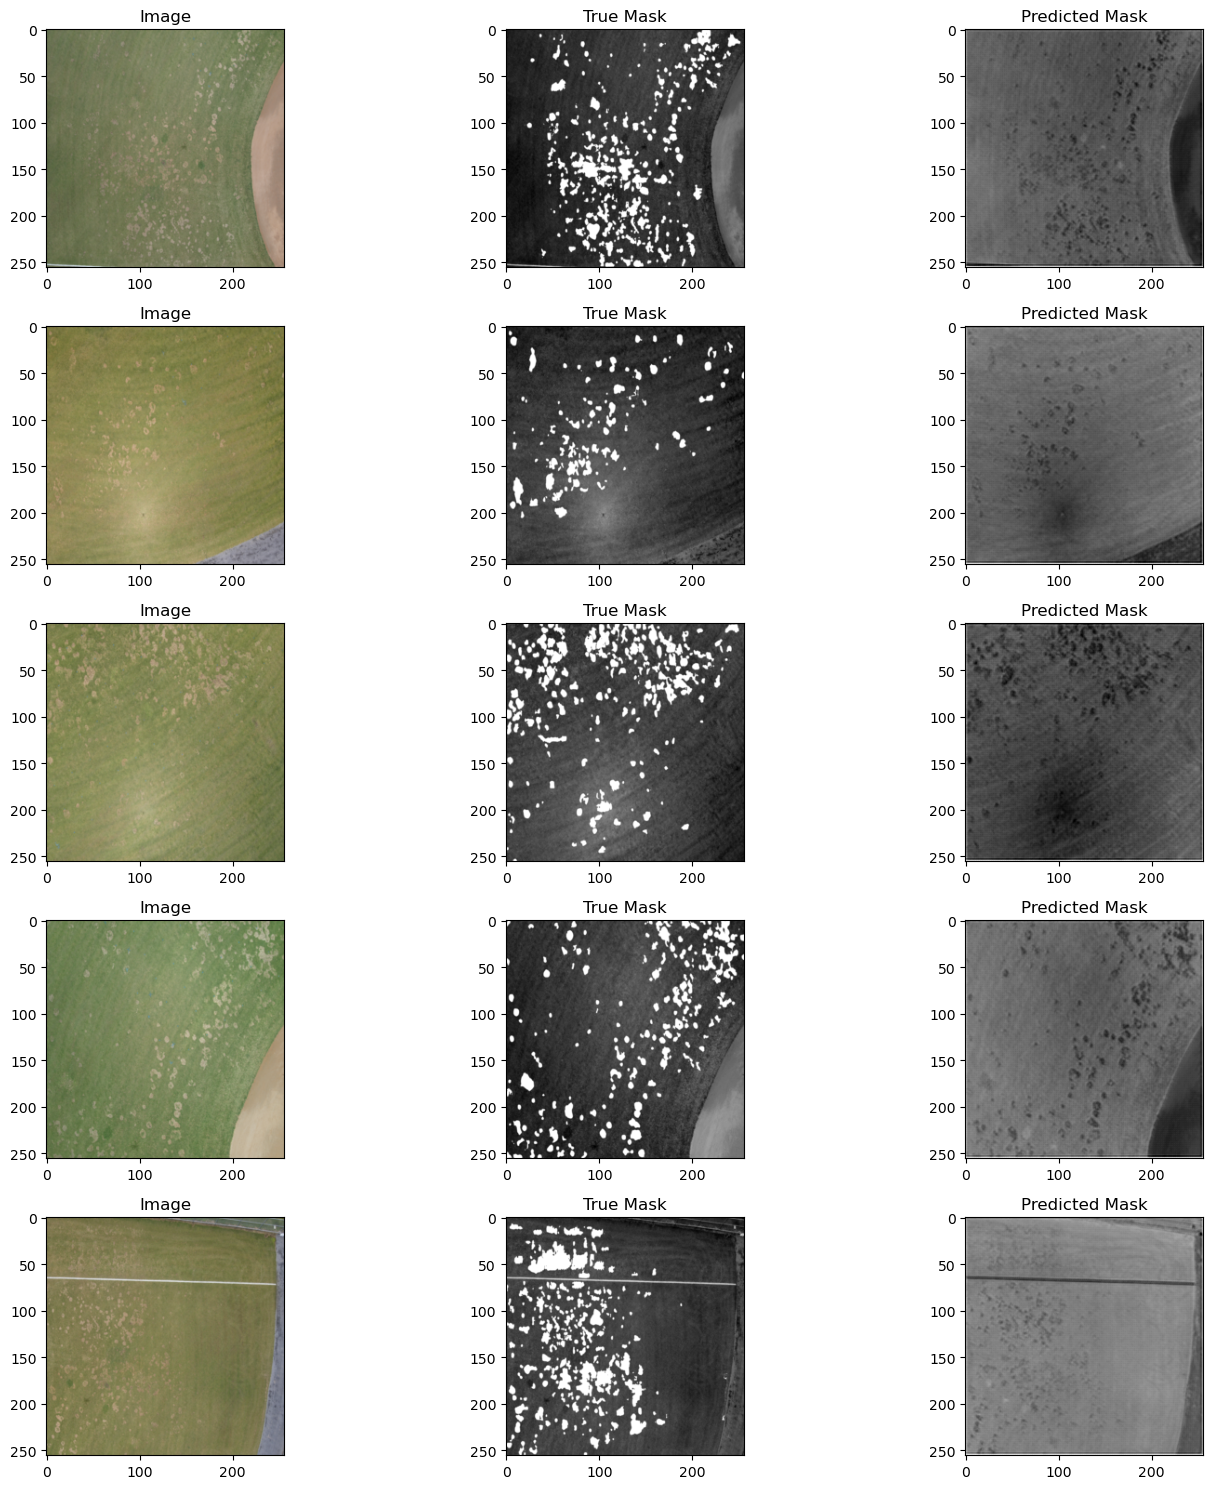

In [59]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score

def visualize_predictions(images, masks_true, masks_pred, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax[0].imshow(images[i].permute(1, 2, 0))  # Assuming images are in RGB format
        ax[0].set_title('Image')

        ax[1].imshow(masks_true[i].squeeze().detach().cpu().numpy(), cmap='gray')  # True mask
        ax[1].set_title('True Mask')

        ax[2].imshow(masks_pred[i].squeeze().detach().cpu().numpy(), cmap='gray')  # Predicted mask
        ax[2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

def evaluate_predictions(predictions, targets, threshold=0.5):
    # Ensure predictions and targets are on CPU and converted to numpy
    predictions = predictions.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    
    # Convert predictions to binary (0 or 1) based on threshold
    predictions_binary = (predictions > threshold).astype(int)
    
    # Flatten tensors for metric calculation
    predictions_flat = predictions_binary.flatten()
    targets_flat = targets.flatten()
    
    # Ensure shapes are consistent
    if predictions_flat.shape != targets_flat.shape:
        raise ValueError(f"Shapes of predictions_flat {predictions_flat.shape} and targets_flat {targets_flat.shape} do not match.")
    
    # Ensure targets are binary (0 or 1)
    targets_binary = (targets_flat > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(targets_binary, predictions_flat)
    
    # Calculate IoU (Jaccard Index)
    iou = jaccard_score(targets_binary, predictions_flat)
    
    return accuracy, iou

# Example usage:
# Assuming test_images_tensor and test_masks_tensor are your tensors
batch_size = test_masks_tensor.size(0)  # Get the batch size

# Generate binary predictions with correct batch size
# Replace with your actual prediction logic
# Ensure binary_predictions are between 0 and 1, representing probabilities
binary_predictions = model(test_images_tensor)  # Replace with your actual model predictions

# Ensure num_images does not exceed batch_size
num_images_to_visualize = min(5, batch_size)

# Evaluate predictions
try:
    test_accuracy, test_iou = evaluate_predictions(binary_predictions, test_masks_tensor)
    print(f"Test Set - Accuracy: {test_accuracy:.4f}, IoU: {test_iou:.4f}")
except ValueError as ve:
    print(f"Error: {ve}")

# Visualize predictions
visualize_predictions(test_images_tensor.cpu(), test_masks_tensor.cpu(), binary_predictions.cpu(), num_images=num_images_to_visualize)


In [81]:
import torch
import torch.nn as nn

class ImprovedUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ImprovedUNet, self).__init__()
        
        # Encoder (downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Decoder (upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2


In [82]:
import torch.nn.functional as F

# Example of Dice Loss for segmentation
def dice_loss(predicted, target, smooth=1e-6):
    intersection = (predicted * target).sum()
    union = predicted.sum() + target.sum()
    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - dice

# Example of Binary Cross-Entropy Loss
criterion = nn.BCEWithLogitsLoss()


Test Set - Accuracy: 0.5603, IoU: 0.5603


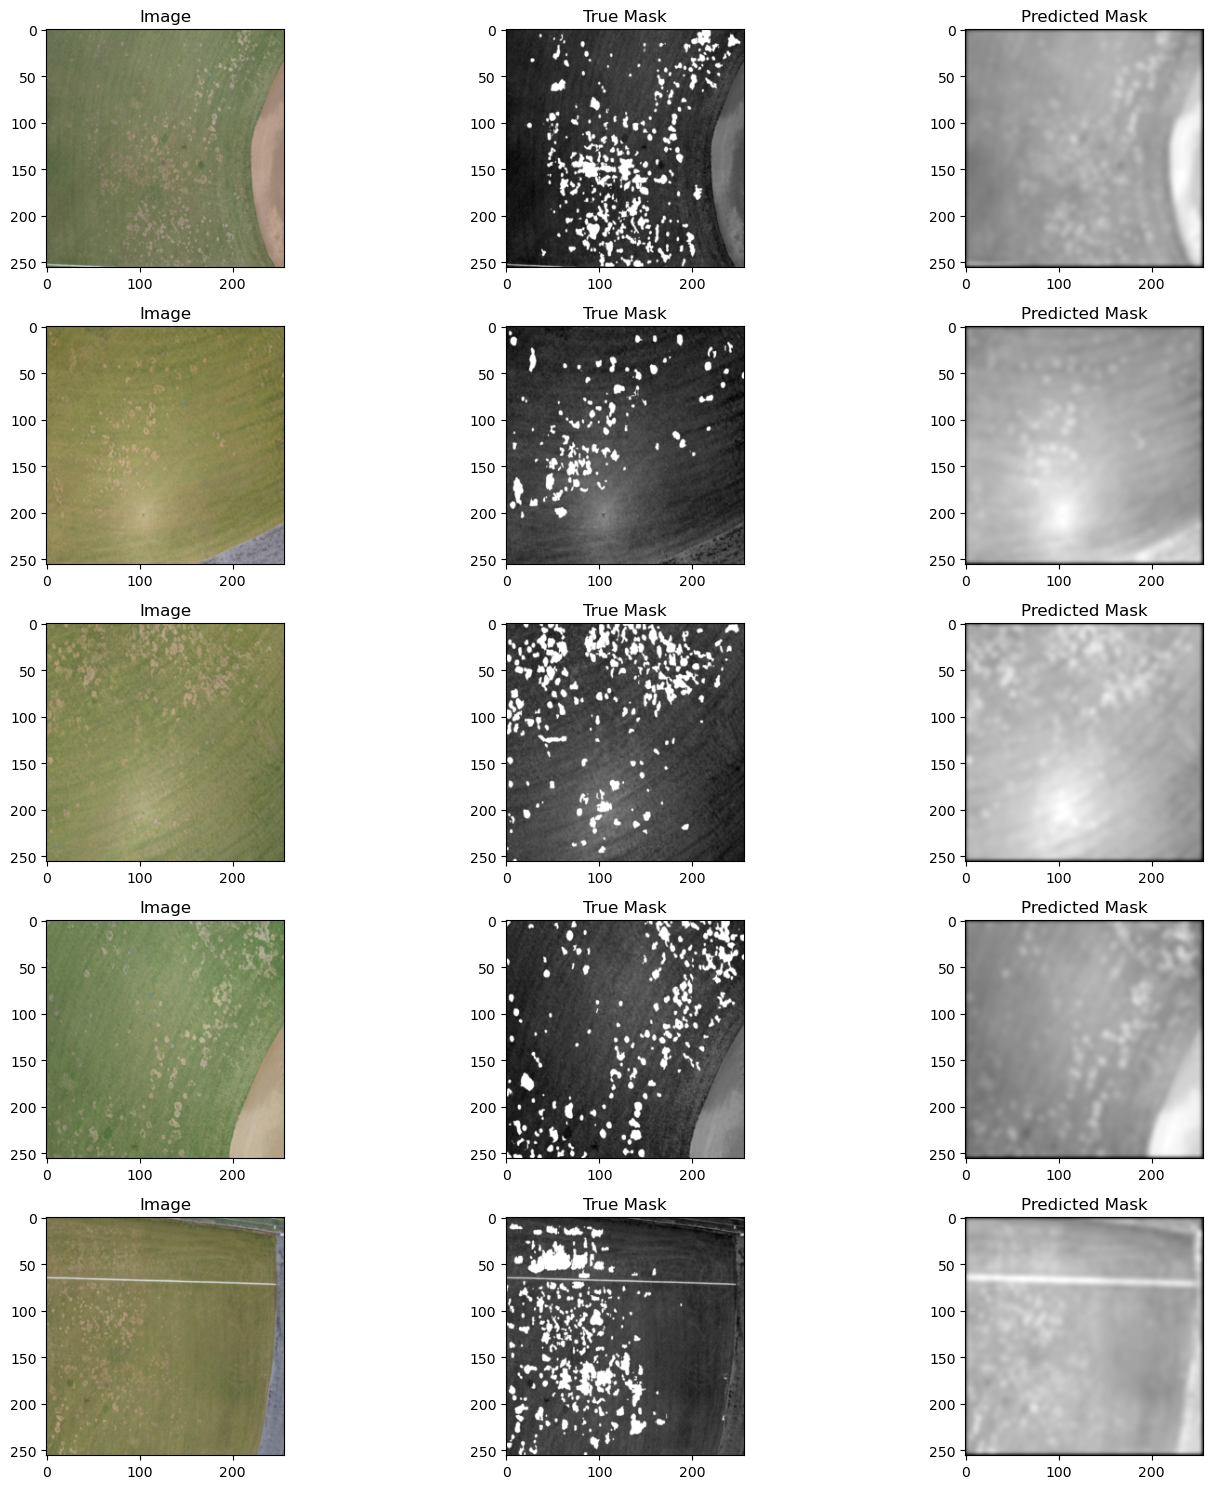

In [83]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, jaccard_score

def visualize_predictions(images, masks_true, masks_pred, num_images=5):
    fig, axes = plt.subplots(num_images, 3, figsize=(15, 15))
    for i in range(num_images):
        ax = axes[i]
        ax[0].imshow(images[i].permute(1, 2, 0))  # Assuming images are in RGB format
        ax[0].set_title('Image')

        ax[1].imshow(masks_true[i].squeeze().detach().cpu().numpy(), cmap='gray')  # True mask
        ax[1].set_title('True Mask')

        ax[2].imshow(masks_pred[i].squeeze().detach().cpu().numpy(), cmap='gray')  # Predicted mask
        ax[2].set_title('Predicted Mask')

    plt.tight_layout()
    plt.show()

def evaluate_predictions(predictions, targets, threshold=0.5):
    # Ensure predictions and targets are on CPU and converted to numpy
    predictions = predictions.cpu().detach().numpy()
    targets = targets.cpu().detach().numpy()
    
    # Convert predictions to binary (0 or 1) based on threshold
    predictions_binary = (predictions > threshold).astype(int)
    
    # Flatten tensors for metric calculation
    predictions_flat = predictions_binary.flatten()
    targets_flat = targets.flatten()
    
    # Ensure shapes are consistent
    if predictions_flat.shape != targets_flat.shape:
        raise ValueError(f"Shapes of predictions_flat {predictions_flat.shape} and targets_flat {targets_flat.shape} do not match.")
    
    # Ensure targets are binary (0 or 1)
    targets_binary = (targets_flat > 0.5).astype(int)
    
    # Calculate accuracy
    accuracy = accuracy_score(targets_binary, predictions_flat)
    
    # Calculate IoU (Jaccard Index)
    iou = jaccard_score(targets_binary, predictions_flat)
    
    return accuracy, iou

# Example usage:
# Assuming test_images_tensor and test_masks_tensor are your tensors
batch_size = test_masks_tensor.size(0)  # Get the batch size

# Generate binary predictions with correct batch size
# Replace with your actual prediction logic
# Ensure binary_predictions are between 0 and 1, representing probabilities
binary_predictions = model(test_images_tensor)  # Replace with your actual model predictions

# Ensure num_images does not exceed batch_size
num_images_to_visualize = min(5, batch_size)

# Evaluate predictions
try:
    test_accuracy, test_iou = evaluate_predictions(binary_predictions, test_masks_tensor)
    print(f"Test Set - Accuracy: {test_accuracy:.4f}, IoU: {test_iou:.4f}")
except ValueError as ve:
    print(f"Error: {ve}")

# Visualize predictions
visualize_predictions(test_images_tensor.cpu(), test_masks_tensor.cpu(), binary_predictions.cpu(), num_images=num_images_to_visualize)
